<a href="https://colab.research.google.com/github/pillaisamarth/clg-proj/blob/main/trends1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Libraries**

In [2]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 887 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# **Setting Default plotting styles**

In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

# **Fetching Stock prices using yfinance Library**

In this section we will get stock prices over four years for Google and Microsoft. However, for analysis, we will focus on Google stock prices for this entire program

In [4]:
tech_list = [
    'GOOG',
    'MSFT'
]

end = datetime.now()
start = datetime(end.year - 4, end.month, end.day)

for stocks in tech_list:
    globals()[stocks] = yf.download(stocks, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# **Function Definitions**

In This section, we will describe some functions later used in the program



In [5]:
def min_max_1000(df):
  sd = df.copy()
  sd['Close'] = (sd['Close'] - sd['Close'].min()) / sd['Close'].max()
  sd['Close'] = sd['Close'] * 1000
  return sd

In [6]:
from sklearn.model_selection import train_test_split
def data_split(X, y, test_size = 0.2):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
  return (X_train, X_test, y_train, y_test)

In [7]:
from sklearn.metrics import mean_squared_error, accuracy_score
def get_score(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)

# Creating DataFrame for Google Stock prices




In [8]:
df = pd.DataFrame(GOOG[['Close']].copy())
df.head()

,Close
Date,
2018-11-26,52.431000
2018-11-27,52.220501
2018-11-28,54.311501
2018-11-29,54.415001
2018-11-30,54.721500


# Scaling Data Between 0 and 1000 using Min Max Scaling

In [9]:
sd = min_max_1000(df)
sd.head()

,Close
Date,
2018-11-26,24.019793
2018-11-27,22.623069
2018-11-28,36.497487
2018-11-29,37.184243
2018-11-30,39.217960


# Calculating and Plotting Moving Average

In this section, we will use a sliding window to calculate the moving average of stock prices to smooth out small term variations and look at the overall movement/behaviour of the stock

In [10]:
moving_average = sd.rolling(
    window = 365,
    center = True,
    min_periods = 183,
).mean()
print(moving_average)

                 Close
Date                  
2018-11-26   51.275575
2018-11-27   51.369184
2018-11-28   51.477131
2018-11-29   51.580850
2018-11-30   51.615616
...                ...
2022-11-18  429.180511
2022-11-21  428.422120
2022-11-22  427.671437
2022-11-23  426.991424
2022-11-25  426.509112

[1008 rows x 1 columns]


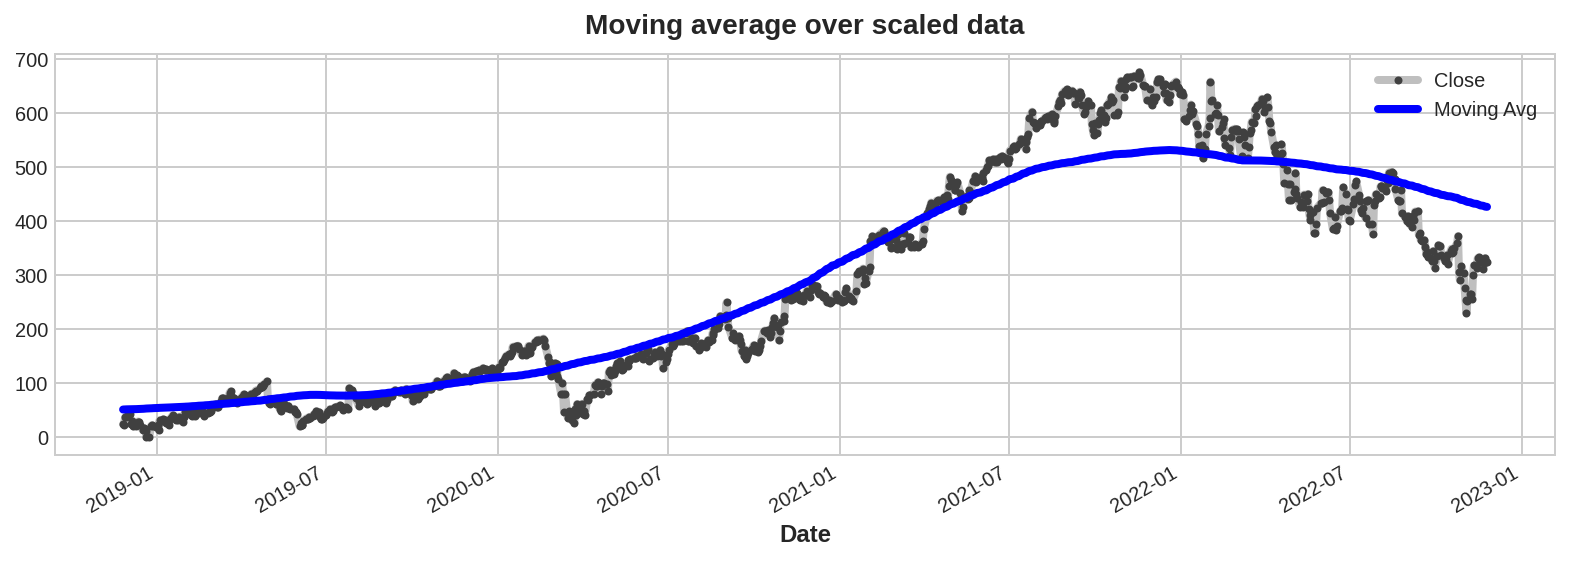

In [11]:
ax = sd.plot(**plot_params)
ax = moving_average.plot(ax = ax, legend = False, color='b')
ax.set_title('Moving average over scaled data')
ax.legend(['Close', 'Moving Avg'])

# Creating trend features for our model

In this section, we will create trend features for our model by taking into account the moving average calculated earlier. It is obvious from the above moving average plot that the trend is atleast not linear. So we will have to take into account polynomial trend of higher degree


In [12]:
from statsmodels.tsa.deterministic import DeterministicProcess
# adding dummy features to learn trend
dp = DeterministicProcess(
    index = sd.index,
    constant = True,
    order = 4,
    drop = True
)

X = dp.in_sample()
X_d = X.copy()

print(X.head())

            const  trend  trend_squared  trend_cubed  trend**4
Date                                                          
2018-11-26    1.0    1.0            1.0          1.0       1.0
2018-11-27    1.0    2.0            4.0          8.0      16.0
2018-11-28    1.0    3.0            9.0         27.0      81.0
2018-11-29    1.0    4.0           16.0         64.0     256.0
2018-11-30    1.0    5.0           25.0        125.0     625.0


# Splitting the data into train and test sets

In [13]:
X_train, X_test, y_train, y_test = data_split(X, sd)
X_train.head()

,const,trend,trend_squared,trend_cubed,trend**4
Date,,,,,
2018-11-26,1.0,1.0,1.0,1.0,1.0
2018-11-27,1.0,2.0,4.0,8.0,16.0
2018-11-28,1.0,3.0,9.0,27.0,81.0
2018-11-29,1.0,4.0,16.0,64.0,256.0
2018-11-30,1.0,5.0,25.0,125.0,625.0


# Performing Linear Regression to get Trend Component


In [14]:
model1 = LinearRegression(fit_intercept = False)
model1.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [15]:

y_pred = pd.Series(model1.predict(X_test).reshape(-1), index = X_test.index)
print(y_pred)
error = get_score(y_test, y_pred)
print(error)

Date
2022-02-08    629.524113
2022-02-09    628.972316
2022-02-10    628.396860
2022-02-11    627.797595
2022-02-14    627.174376
                 ...    
2022-11-18   -142.723989
2022-11-21   -151.231354
2022-11-22   -159.798314
2022-11-23   -168.425088
2022-11-25   -177.111893
Length: 202, dtype: float64
32918.615126838886


Text(0.5, 1.0, 'Forecasting stock prices (Bi - Quadratic Trend)')

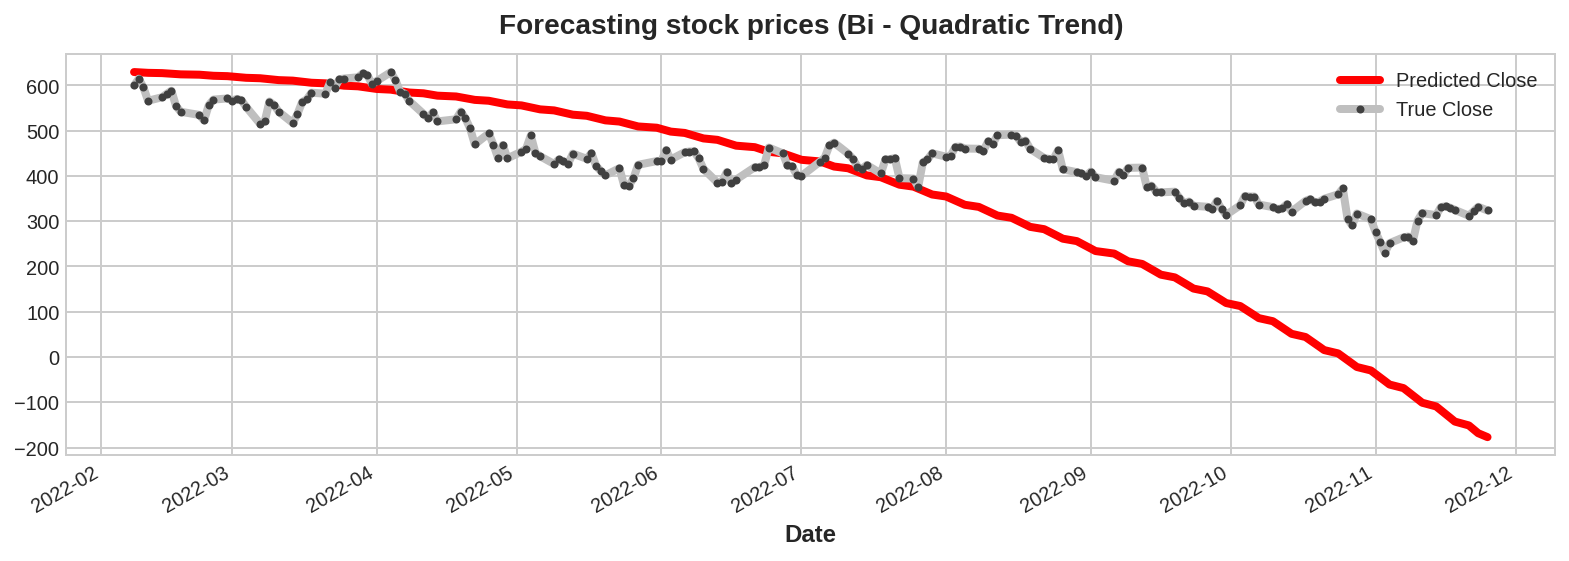

In [16]:
ax = y_pred.plot(color='r')
ax = y_test.plot(ax = ax, **plot_params)
ax.legend(['Predicted Close', 'True Close'])
ax.set_title("Forecasting stock prices (Bi - Quadratic Trend)")

In [17]:
y_train_pred = pd.DataFrame(model1.predict(X_train).reshape(-1), index = X_train.index)

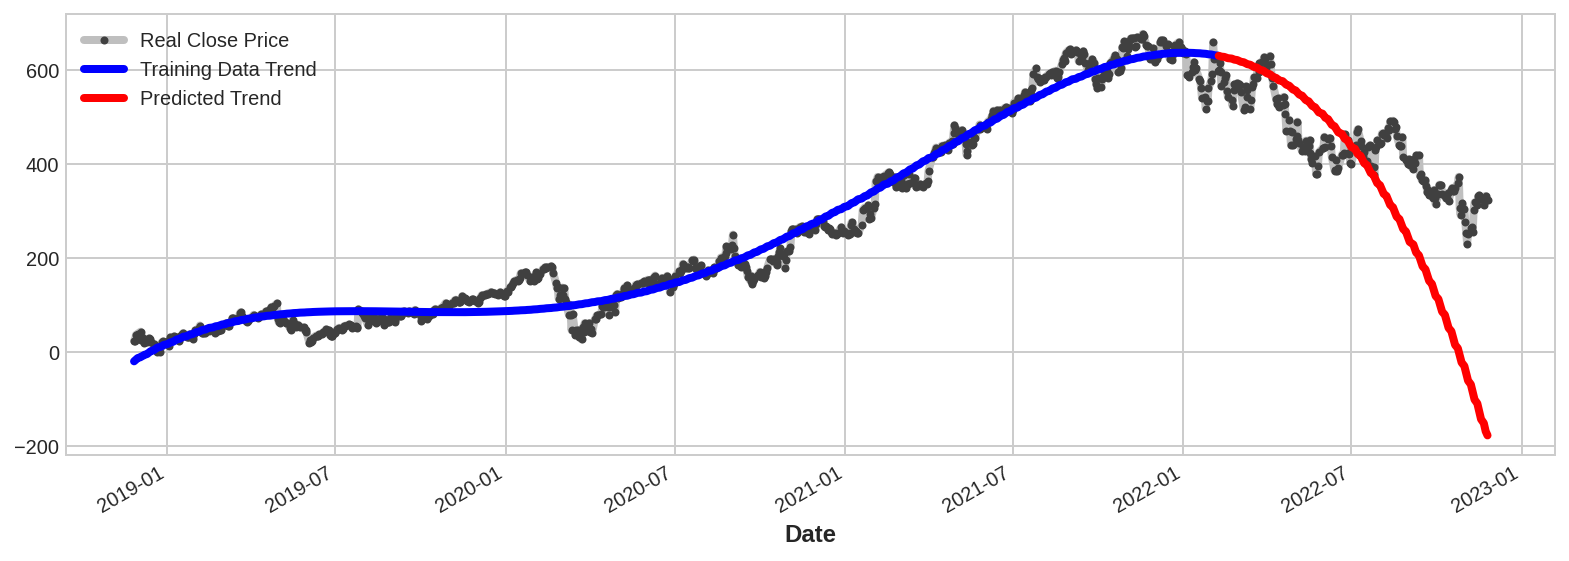

In [18]:
ax = sd['Close'].plot(**plot_params, legend = True)
ax = y_train_pred.plot(ax = ax, color='b')
ax = y_pred.plot(ax = ax, color = 'r')
ax.legend(['Real Close Price', 'Training Data Trend', 'Predicted Trend'])

In [19]:
y_train.head()

,Close
Date,
2018-11-26,24.019793
2018-11-27,22.623069
2018-11-28,36.497487
2018-11-29,37.184243
2018-11-30,39.217960


In [20]:
y_cmp = y_train.copy()
y_cmp['Close'] = y_train_pred

In [21]:
y_cmp.head()

,Close
Date,
2018-11-26,-19.727262
2018-11-27,-17.937920
2018-11-28,-16.169334
2018-11-29,-14.421367
2018-11-30,-12.693878


In [22]:
y_train.head()

,Close
Date,
2018-11-26,24.019793
2018-11-27,22.623069
2018-11-28,36.497487
2018-11-29,37.184243
2018-11-30,39.217960


# Creating Detrended Data

In this section, we will create detrended data (stationary data, since there is no apparent seasonality present in the data) by substracting trend component from the original data

In [23]:
detrended_data = y_train - abs(y_cmp)
detrended_data.head()

,Close
Date,
2018-11-26,4.292530
2018-11-27,4.685150
2018-11-28,20.328152
2018-11-29,22.762876
2018-11-30,26.524082


In [24]:
y_cmp.head()

,Close
Date,
2018-11-26,-19.727262
2018-11-27,-17.937920
2018-11-28,-16.169334
2018-11-29,-14.421367
2018-11-30,-12.693878


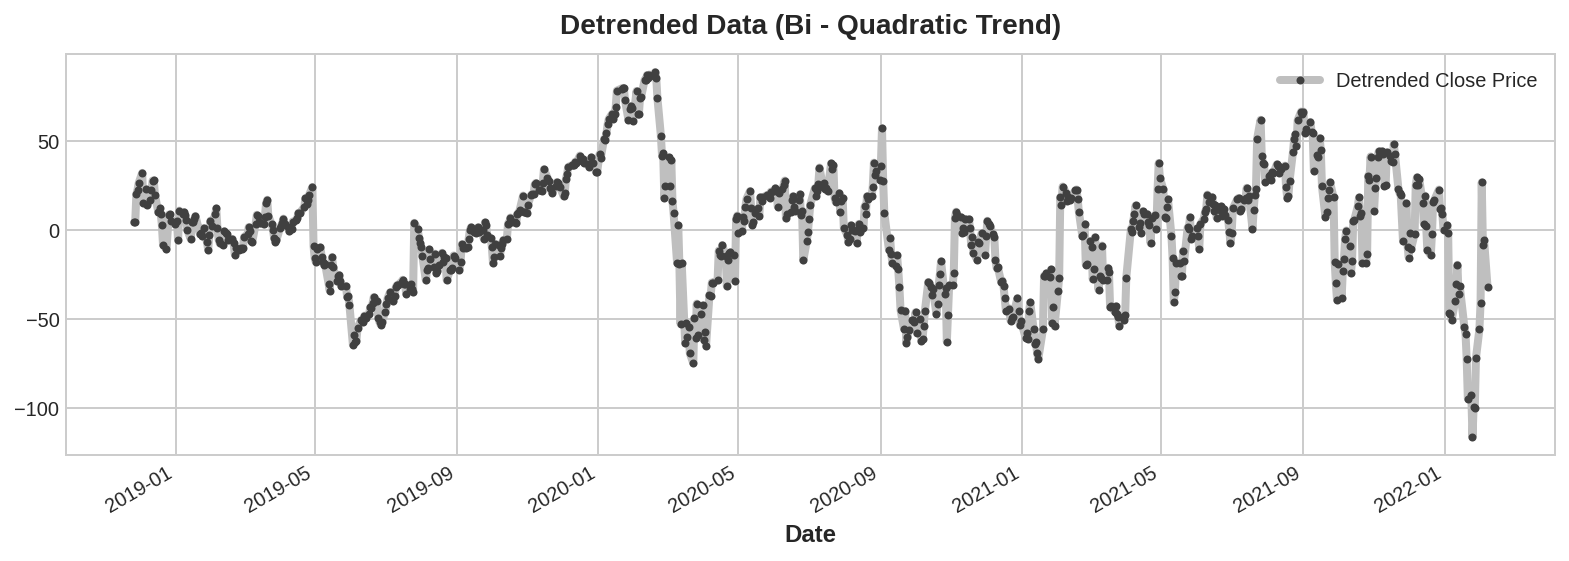

In [25]:
ax = detrended_data.plot(**plot_params)
ax.set_title('Detrended Data (Bi - Quadratic Trend)')
ax.legend(['Detrended Close Price'])

Text(0.5, 1.0, 'Stock price (scaled)')

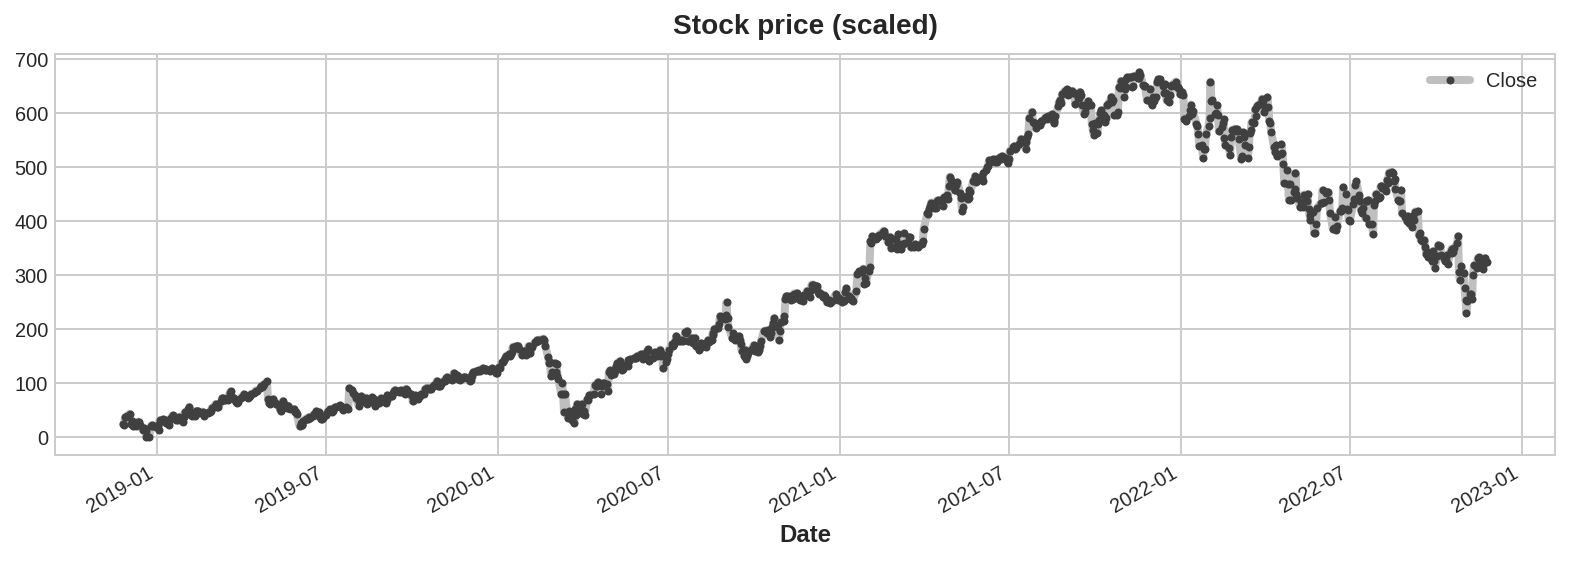

In [26]:
ax = sd.plot(**plot_params)
ax.set_title('Stock price (scaled)')

In [30]:
sd.describe()

,Close
count,1008.000000
mean,290.113371
std,206.664206
min,0.000000
25%,94.403778
50%,253.780451
75%,464.414860
max,676.124180


Close    676.12418
dtype: float64